In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 6)

df = pd.read_csv("/content/student-mat.csv")
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
df.info()
print("\nКоличество пропусков по каждому признаку:")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


Пропусков в данных нет, можем сразу переходить к анализу данных.

## EDA

### Визуализация

In [ ]:
# Добавим бинарную целевую переменную: 1 - высокая итоговая оценка, 0 - низкая
df['HighGrade'] = (df['G3'] >= 10).astype(int)
df['HighGrade'].value_counts()

,count
HighGrade,
1,265
0,130


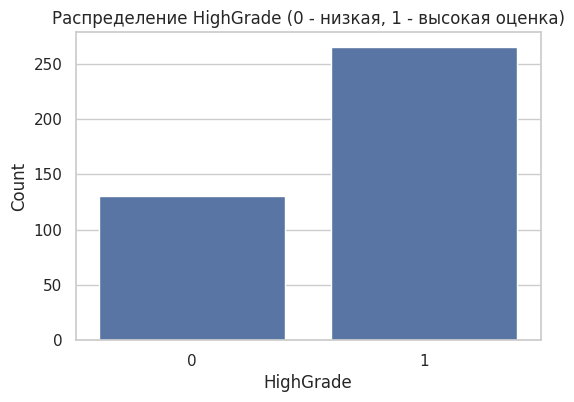

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='HighGrade', data=df)
plt.title('Распределение HighGrade (0 - низкая, 1 - высокая оценка)')
plt.xlabel('HighGrade')
plt.ylabel('Count')
plt.show()

Большая часть учеников имеет высокую оценку, а меньшая часть - низкую


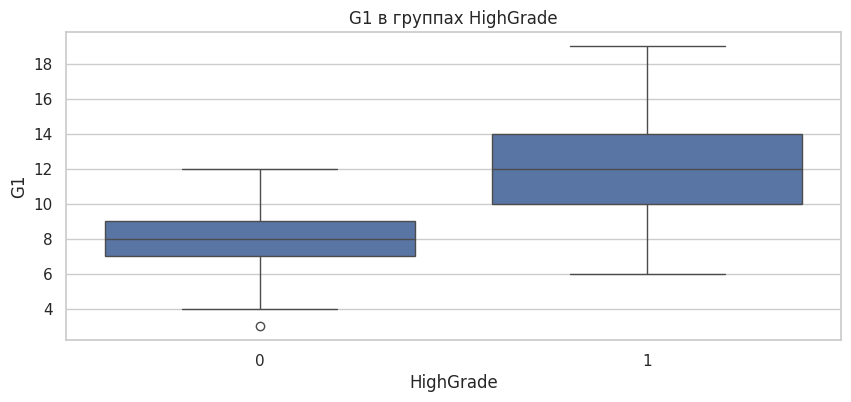

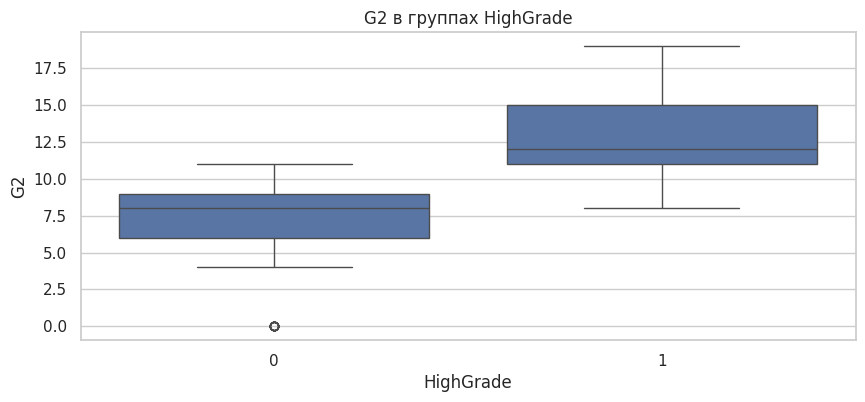

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x='HighGrade', y='G1', data=df)
plt.title('G1 в группах HighGrade')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='HighGrade', y='G2', data=df)
plt.title('G2 в группах HighGrade')
plt.show()

По boxplot мы видим, что у группы с высокой итоговой оценкой, промежуточные оценки заметно выше

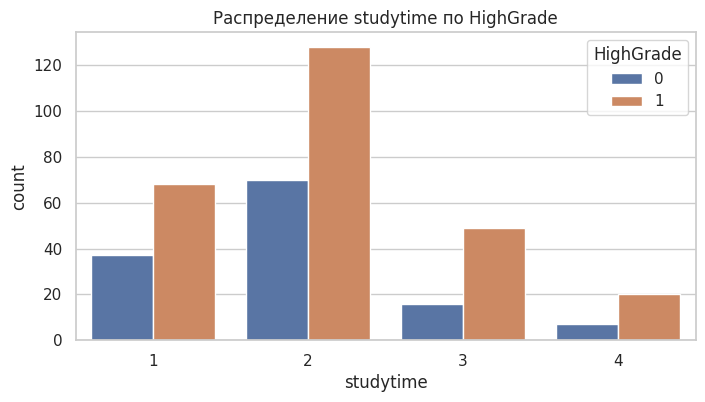

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='studytime', hue='HighGrade', data=df)
plt.title('Распределение studytime по HighGrade')
plt.show()

Студенты, которые учатся больше, получают высокую итоговую оценку.


### Корреляции

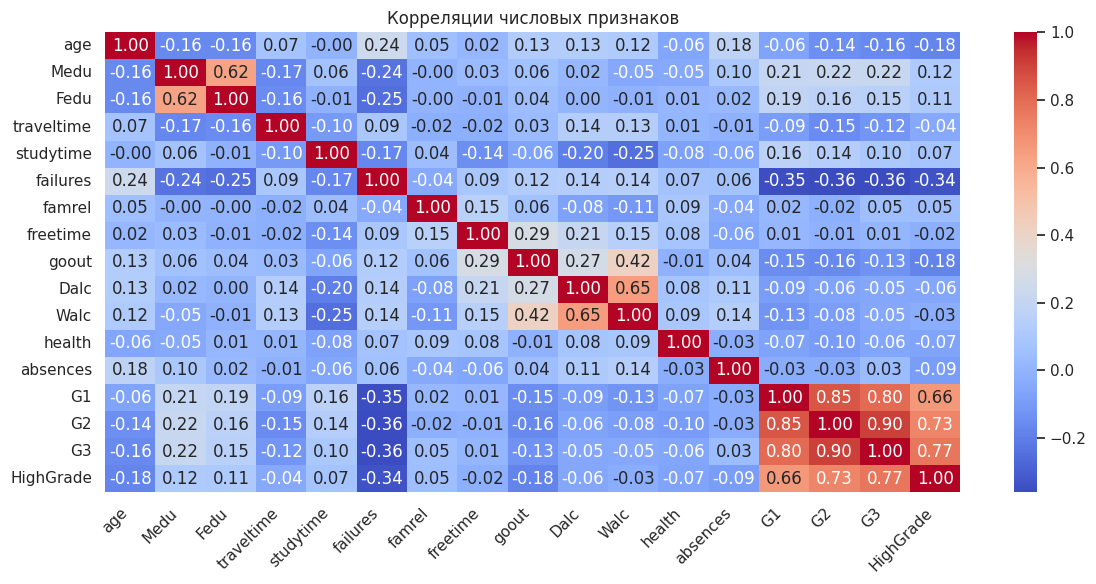

,HighGrade
HighGrade,1.000000
G3,0.770042
G2,0.725407
G1,0.664979
Medu,0.115396
Fedu,0.108057
studytime,0.074613
famrel,0.046683
freetime,-0.018321
Walc,-0.029957


In [ ]:
plt.figure(figsize=(12,6))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Корреляции числовых признаков')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

corr['HighGrade'].sort_values(ascending=False)

С наибольшей корреляцией переменной HighGrade связаны G2 и G1 — промежуточные оценки
- отрицательная связь у failures
- слабые зависимости у признаков, связанных с алкоголем, здоровьем и тд


### Хи-квадрат для категориальных признаков

In [ ]:
best_features = ["sex", "address", "famsize", "Pstatus", "schoolsup",
                  "famsup", "paid", "activities", "higher", "internet", "romantic"]

for col in best_features:
    table = pd.crosstab(df[col], df["HighGrade"])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"H_0 - {p > 0.05}\tДля {col} и HighGrade: p-value = {p:.4f}, chi2 = {chi2:.3f}")

H_0 - True	Для sex и HighGrade: p-value = 0.1949, chi2 = 1.680
H_0 - True	Для address и HighGrade: p-value = 0.3626, chi2 = 0.829
H_0 - True	Для famsize и HighGrade: p-value = 0.4756, chi2 = 0.509
H_0 - True	Для Pstatus и HighGrade: p-value = 0.4840, chi2 = 0.490
H_0 - True	Для schoolsup и HighGrade: p-value = 0.0680, chi2 = 3.331
H_0 - True	Для famsup и HighGrade: p-value = 0.2859, chi2 = 1.139
H_0 - True	Для paid и HighGrade: p-value = 0.0829, chi2 = 3.008
H_0 - True	Для activities и HighGrade: p-value = 0.8890, chi2 = 0.019
H_0 - False	Для higher и HighGrade: p-value = 0.0039, chi2 = 8.353
H_0 - True	Для internet и HighGrade: p-value = 0.2781, chi2 = 1.176
H_0 - True	Для romantic и HighGrade: p-value = 0.0674, chi2 = 3.345


Гипотезы:

- **H0**: признак и целевая переменная *независимы*;
- **H1**: есть статистически значимая зависимость.

Если `p-value < 0.05`, отвергаем `H0` и считаем, что между признаком и HighGrade есть связь.

### Аномалии

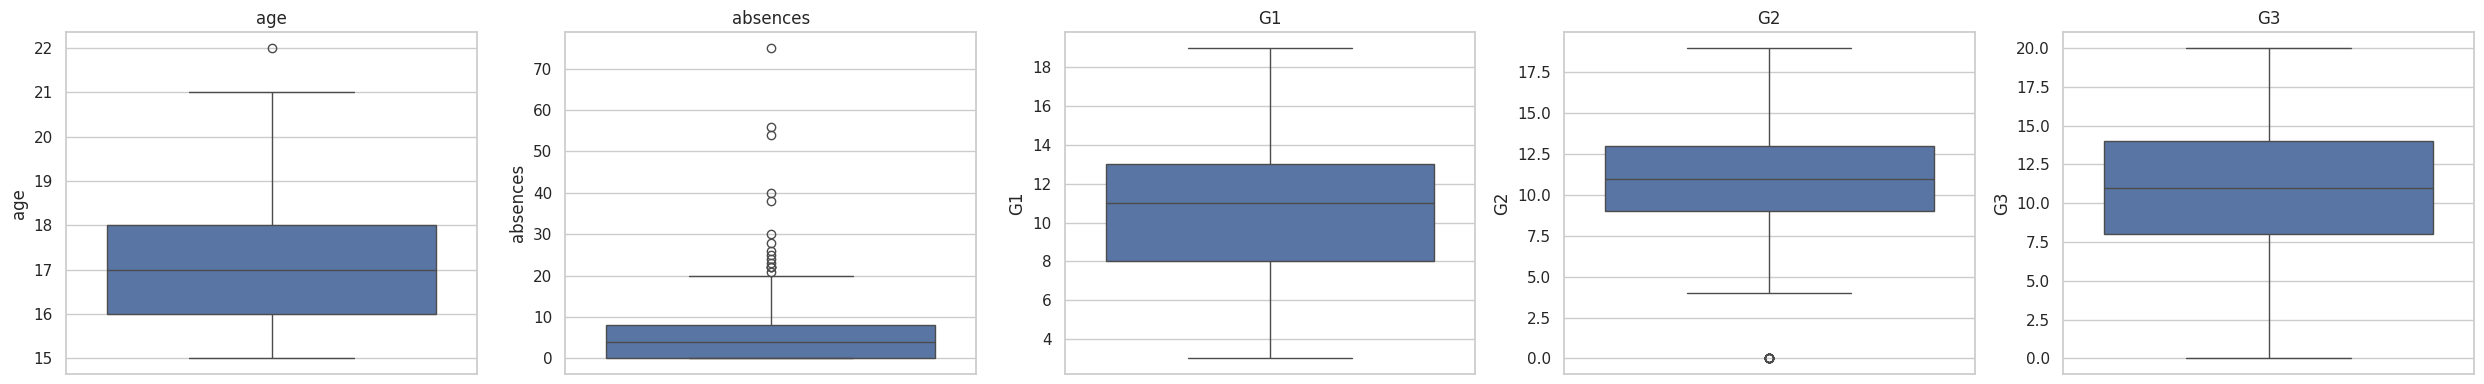

In [ ]:
num_cols = ['age', 'absences', 'G1', 'G2', 'G3']
fig, axes = plt.subplots(1, len(num_cols), figsize=(5 * len(num_cols), 4))

for ax, col in zip(axes, num_cols):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

По boxplot видно, что:
- у признака **absences** есть выбросы (ученики с аномально большим числом пропусков);
- у оценок **G1**, **G2**, **G3** есть крайние значения (0 и 20), но в целом распределение компактное;
- возраст **age** сконцентрирован в интервале 15–18 лет.

### Проверка на пропуски

In [ ]:
df.isnull().sum().sum()

np.int64(0)

Пропусков в данных нет, все признаки заполнены.

## Подготовка данных для моделей

In [ ]:
# Разделим признаки на числовые и категориальные
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(df.select_dtypes(include=['int64', 'float64']).columns)

# Целевая переменная - HighGrade, не должна входить в список признаков
numeric_features = [col for col in numeric_features if col != 'HighGrade']

binary_cols = [col for col in categorical_features if df[col].nunique() == 2]
multi_cols = [col for col in categorical_features if df[col].nunique() > 2]

binary_cols, multi_cols

(['school',
  'sex',
  'address',
  'famsize',
  'Pstatus',
  'schoolsup',
  'famsup',
  'paid',
  'activities',
  'nursery',
  'higher',
  'internet',
  'romantic'],
 ['Mjob', 'Fjob', 'reason', 'guardian'])

In [ ]:
# LabelEncoder для бинарных категориальных признаков
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
# OneHotEncoder для остальных категориальных признаков
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[multi_cols])

X_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(multi_cols))

# Удалим исходные мультикатегориальные признаки и добавим one-hot
df_model = df.drop(multi_cols, axis=1)
df_model = pd.concat([df_model.reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)

df_model.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,0,0,4,4,2,2,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,17,1,0,1,1,1,1,2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,15,1,1,1,1,1,1,2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,15,1,0,1,4,2,1,3,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,16,1,0,1,3,3,1,2,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Полный набор признаков
X = df_model.drop(columns=['HighGrade', 'G3'])
y = df_model['HighGrade']

# Разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

print(X.shape, X_train.shape, X_test.shape)

(395, 45) (264, 45) (131, 45)


In [ ]:
# Набор отобранных признаков (best_features)
best_features = ['G1', 'G2', 'failures', 'studytime', 'absences',
                 'goout', 'Dalc', 'Walc', 'age']

X_best = df_model[best_features]

X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X_best, y, test_size=0.33, random_state=42
)

X_best.shape, X_train_best.shape, X_test_best.shape

((395, 9), (264, 9), (131, 9))

## Model №1
Логистическая регрессия на отобранных признаках (best_features)

In [ ]:
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train_best, y_train_best)

y_pred = model1.predict(X_test_best)

acc = accuracy_score(y_test_best, y_pred)
ppv = precision_score(y_test_best, y_pred)
Re = recall_score(y_test_best, y_pred)
f1 = f1_score(y_test_best, y_pred)
auc = roc_auc_score(y_test_best, y_pred)

print(f"=== Метрики ===\n"
      f"Точность (accuracy)    - {round(acc, 3)}\n"
      f"Прецизионность (precision) - {round(ppv, 3)}\n"
      f"Полнота (recall)       - {round(Re, 3)}\n"
      f"F1-мера                - {round(f1, 3)}\n"
      f"ROC-AUC                - {round(auc, 3)}")

=== Метрики ===
Точность (accuracy)    - 0.908
Прецизионность (precision) - 0.916
Полнота (recall)       - 0.938
F1-мера                - 0.927
ROC-AUC                - 0.899


## Model №2
Логистическая регрессия на всех признаках

In [ ]:
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

acc = accuracy_score(y_test, y_pred)
ppv = precision_score(y_test, y_pred)
Re = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"=== Метрики ===\n"
      f"Точность (accuracy)    - {round(acc, 3)}\n"
      f"Прецизионность (precision) - {round(ppv, 3)}\n"
      f"Полнота (recall)       - {round(Re, 3)}\n"
      f"F1-мера                - {round(f1, 3)}\n"
      f"ROC-AUC                - {round(auc, 3)}")

=== Метрики ===
Точность (accuracy)    - 0.924
Прецизионность (precision) - 0.938
Полнота (recall)       - 0.938
F1-мера                - 0.938
ROC-AUC                - 0.919


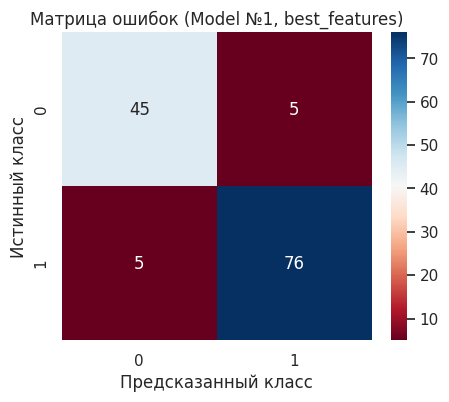

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_best, y_pred), annot=True, fmt='d', cmap='RdBu')
plt.title('Матрица ошибок (Model №1, best_features)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

Матрица ошибок показывает, сколько объектов каждая модель классифицировала верно и неверно в разрезе классов `0` и `1`. Это помогает понять, какие ошибки (ложноположительные или ложноотрицательные) преобладают.